#### Copyright 2020 Google LLC.

In [3]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Linear Regression with TensorFlow

In previous units we learned about regression and about how to build and apply a regression model using [scikit-learn](https://scikit-learn.org/stable/). For many regression cases, `scikit-learn` is more than adequate. However, there are times when more powerful tools are needed. [TensorFlow](https://www.tensorflow.org/) is one of those tools. It is a computational toolkit built to perform machine learning and data science tasks at scale.

## Problem Framing

Machine learning is one of a variety of solutions that might work for solving a problem. It is always important to understand the problem space before diving in and starting to clean data and code.

In this lab we would like to be able to **predict the price of a house**.

Questions we should ask ourselves might include the following:

* Predict the price when? Now? In the past? In the future? For what range?
* Where are we predicting prices for? One market? One state? One country?
* What is our tolerance for being wrong?
* Are we okay with a few huge outliers if the overall model is better?
* What metrics are we using to define success and what are the acceptable values?
* Is there an non-ML way to solve this problem?
* What data is available to solve the problem?

The list of questions is boundless. Eventually you'll need to move on, but understanding the problem and the solution space is vital.

---

For this problem we'll further define the problem by saying:

>  We want to create a system that predicts the prices of houses in California in 1990. We have census data from 1990 available to build and test the system. We will accept a system with a root mean squared error of 200,000 or better.

Since this is a contrived example, we'll shortcut around the question of choosing a technique and say that our analysis has led us to believe that we want to use a linear regression model to serve as our prediction system.

## Exploratory Data Analysis

The dataset we'll use for this Colab contains California housing data taken from the 1990 census data. This is a popular dataset for experimenting with machine learning models.

As with any data science project, it is a good idea to take some time and review the [data schema and description](https://www.kaggle.com/camnugent/california-housing-prices). Ask yourself the following:

* What data is available? What are the columns?
* What do those columns mean?
* What data types are those columns?
* What is the granularity of the data? In this particular case, what is a "block"?
* How many rows of data are there?
* Roughly how big is the data? Kilobytes? Megabytes? Gigabytes? Terabytes? More?
* Are any of the columns highly correlated?
* What bias is contained in the data?

### Load the Data

Now that we have an understanding of the data that we are going to use in our model, let's load it into this Colab and examine it more closely.

Since the data is [hosted on Kaggle](https://www.kaggle.com/camnugent/california-housing-prices), you'll need to upload your `kaggle.json` file to this lab and then run the code block below.

In [4]:
! chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && mv kaggle.json ~/.kaggle/ && echo 'Done'

chmod: kaggle.json: No such file or directory


Once you are done, use the `kaggle` command to download the file into the lab.

In [5]:
!kaggle datasets download camnugent/california-housing-prices
!ls

california-housing-prices.zip: Skipping, found more recently modified local copy (use --force to force download)
Linear_Regression_with_TensorFlow.ipynb slides.md
california-housing-prices.zip           slides.pptx
colab-key.zip


We now have a file called `california-housing-prices.zip` that we can load into a `DataFrame`.

In [6]:
import pandas as pd

housing_df = pd.read_csv('california-housing-prices.zip')

housing_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


### Exploration

You should always look at your data and statistics about that data before you begin modelling it. First, let's see the columns and data types that we have available.

In [7]:
housing_df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

Eight floating point features, one object features, and a floating point target, `median_house_value`. This is what we expect based on the [data documentation](https://www.kaggle.com/camnugent/california-housing-prices).

#### Statistics

It is a good idea to also describe the dataset. We use the `include='all'` argument to ensure our object column is also described.

In [8]:
housing_df.describe(include='all')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1H OCEAN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9136
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,NaN
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,NaN
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,NaN
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,NaN
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,NaN
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,NaN


In this case we can see that all of the column counts are the same except for `total_bedrooms`, which seems to be missing some data.

Looking at the min and max can be helpful, too. Does a 2.0 value for a minimum number of rooms for a block match your mental model of what a block is? What about that max of 39,320 rooms? In cases like this, it can be useful to [research your topic area](https://www2.census.gov/geo/pdfs/reference/GARM/Ch11GARM.pdf).

In this particular case, those numbers might be okay as long as the dense block is in an urban area with very dense and tall buildings on the block. As you probe a dataset, you should ask yourself questions like this. When something doesn't look right, investigate it.

Also notice the ocean proximity column. It has five unique values. Let's see what they are.

<AxesSubplot:>

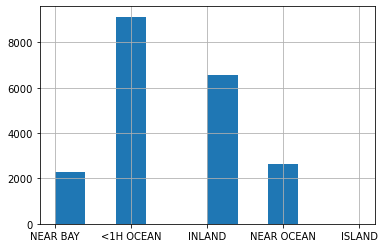

In [9]:
housing_df['ocean_proximity'].hist()

We used `.hist()` so that we can also see the distribution. We can see the five values and can see that the largest group is `<1H OCEAN`. We don't seem to have any values missing.

##### Exercise 1: Sanity Check

Use Pandas to find the row of data that contains the census block with the largest number of rooms. Search for the latitude and longitude for that location and answer the questions below.

**Student Solution**

In [10]:
# Your Code Goes Here
import pandas as pd

beds = housing_df['total_rooms']

max_value = beds.max()


maxRoom = housing_df[housing_df['total_rooms'] == max_value]
maxRoom



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13139,-121.44,38.43,3.0,39320.0,6210.0,16305.0,5358.0,4.9516,153700.0,INLAND


1. What city is the block located in?
> *Elk Grove California
1. Are 39320.0 total rooms reasonable? Why?
> It's reasonable



---

#### Sampling

It is also a good idea to take a look at the actual data. We can use Panda's `head()`, `tail()`, and/or `sample()` methods to do this.

In [11]:
housing_df.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


Did you gain any insight from peeking at the actual data? Is the data sorted in a manner that might lead to a bad model?

In this case the data seems to be sorted ascending by longitude and possibly secondarily descending by latitude. We need to consider this when sampling or splitting the data.

Also, there are some duplicate latitude and longitude values. This seems odd, but will be difficult to troubleshoot. For now, we'll just accept that the values are okay.

#### Correlation

It is important to understand how columns relate to one another. Every feature that you add to your training set increases the amount of work that must be done to train your model. If you can find columns with a high degree of correlation, you can potentially not use one of the columns in your training and still get a model that performs well.

Let's create a correlation matrix heatmap for our data set.

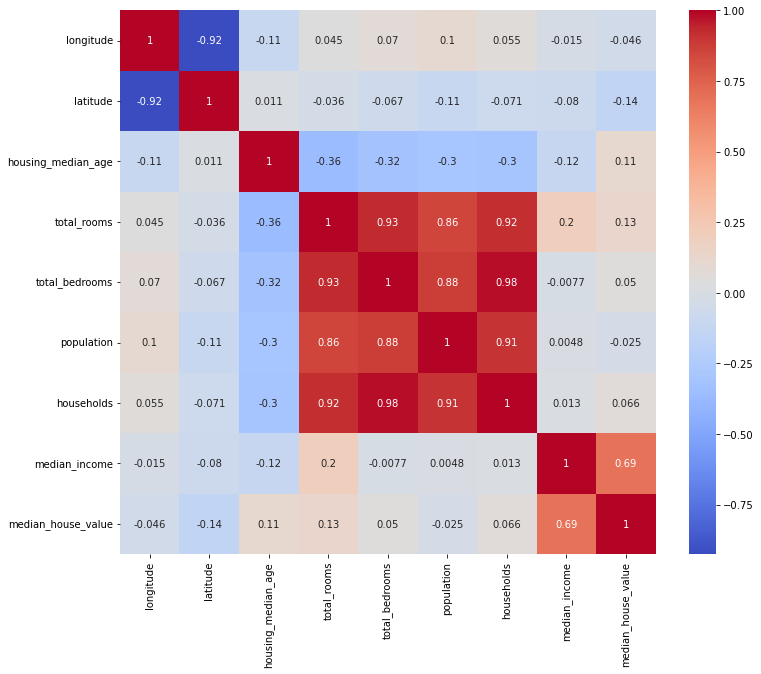

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,10))
_ = sns.heatmap(housing_df.corr(), cmap='coolwarm', annot=True)

##### Exercise 2: Correlated Columns

Answer the following questions about the correlation between columns in our dataset.

**Student Solution**

1. Which columns are the most highly correlated?
> Households and total bedrooms
1. Which column is most strongly correlated with `median_house_value`?
> median house values and median inccome
1. Which columns have the strongest negative correlation?
> Longitude and Latitude



---

### Data Preprocessing

Now is the stage where we would perform model-independent preprocessing to the data to repair any missing data. Since there isn't very much missing data, we don't have much pre-processing to do.

Let's look at those room counts again, though. The values seem a little odd.

First we'll plot the room counts in ascending order.

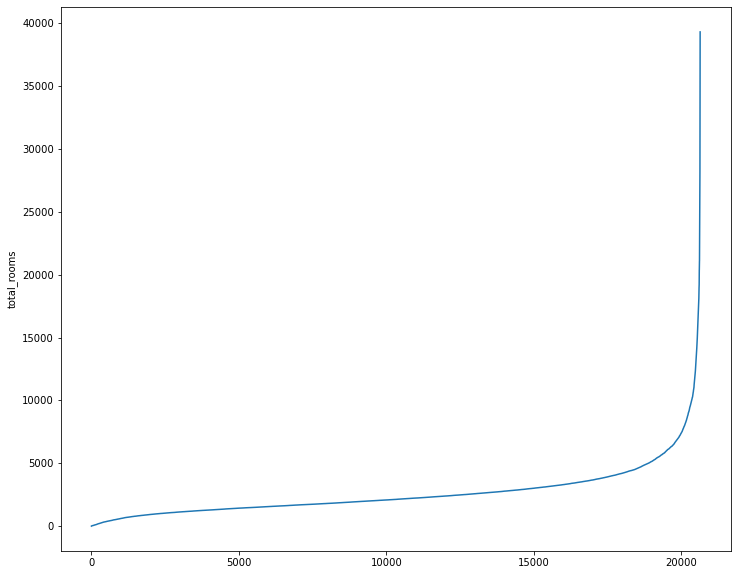

In [13]:
rooms = housing_df['total_rooms'].sort_values().reset_index(drop=True)

plt.figure(figsize=(12,10))
_ = sns.lineplot(x=rooms.index.values, y=rooms)

That's quite a spike there at the end!

Looking at the chart, let's pick a point where the number of rooms really starts to extremely slope upward, say 10,000. If we chose to drop the rows with really large values, what would that do to our data?

In [14]:
many_rooms = rooms[rooms > 10000].size

percent = (many_rooms / rooms.size) * 100

print(f'{many_rooms} blocks have more than 10000 rooms ' +
      f'which is {percent:0.2f}% of our data')

287 blocks have more than 10000 rooms which is 1.39% of our data


So we'd knock out over 1% of our data by trying to remove what we think are outliers. That's not horrible, but it's probably not something we would want to do on a hunch.


We do need to fix our missing total bedrooms data. There are a few strategies that we could use:

* Fill in the values with the mean of the `total_bedrooms` data in the dataset.
* Fill in the values with zero.
* Find the closest lat/long values and use the mean of them.
* Find the ratio of `total_bedrooms` to `total_rooms` and multiply it against the `total_rooms` values that correspond with the missing `total_bedrooms` values.

Which is best?

Each method has pros and cons. For instance, using the dataset-wide mean values might lead to some unrealistic values if the blocks happen to be in extremely dense or extremely rural areas.

Filling in with zeros in this case works, but seems like a lazy approach that we can be pretty sure is not accurate.

Finding the closest lat/long that has a value and using its value - or the mean of a few of the closest lat/longs - is tempting since density probably changes slowly. However, this might be difficult to do, even with the data being sorted by latitude and longitude.

Finding the ratio of total rooms to bedrooms seems like a reasonable compromise since we have `total_rooms` data for every row, and the two columns are highly correlated. Using these values, we can derive a reasonable guess for the number of bedrooms.

The code to find the ratio sums the values for total bedrooms and total rooms across all fully-populated rows in the dataset.

In [15]:
has_all_data = housing_df[~housing_df['total_bedrooms'].isna()]

sums = has_all_data[['total_bedrooms', 'total_rooms']].sum().tolist()

bedrooms_to_total_rooms_ratio = sums[0] / sums[1]

bedrooms_to_total_rooms_ratio

0.20400898497877112

If we think that the outliers might throw off the ratio, we can check the median.

In [16]:
has_all_data = housing_df[~housing_df['total_bedrooms'].isna()]

sums = has_all_data[['total_bedrooms', 'total_rooms']].median().tolist()

bedrooms_to_total_rooms_ratio = sums[0] / sums[1]

bedrooms_to_total_rooms_ratio

0.20451339915373765

It seems to match the mean pretty closely.

Now we just need to patch the data.

In [17]:
missing_total_bedrooms_idx = housing_df['total_bedrooms'].isna()

housing_df.loc[missing_total_bedrooms_idx, 'total_bedrooms'] = housing_df[
    missing_total_bedrooms_idx]['total_rooms'] * bedrooms_to_total_rooms_ratio

housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.732315,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,420.856140,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,295.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Modeling

It is time to actually build our model. In this case, we know we are going to build a linear regression model using TensorFlow. We could build the model by hand, but luckily we don't have too. TensorFlow provides many pre-built models in [its estimator library](https://www.tensorflow.org/api_docs/python/tf/estimator). We are going to use the [`tensorflow.estimator.LinearRegressor`](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor) model.

The [`Estimator`](https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator) class is the base class for TensorFlow estimators. Its methods define the API for estimators. In the remainder of this lab, we will create an instance of `LinearRegressor` and use the `Estimator` API to train the model and make test predictions.

### Prepare the Data

Earlier we considered preprocessing the data. That preprocessing was intended to be more generic preprocessing that needed to be done to correct errors with the data set.

Now that we have chosen a model, we need to do specific preprocessing related to the type of model that we'll be building and how we are going to test and train the model.

Initially we'll be using the `LinearRegressor` with default options. For measuring model quality, we will perform hold-out testing with 20% of the data being held out for test.

#### Normalization

The scale and range of data in each column of our dataset varies widely. In many models larger values will be over-considered in training. In order to combat this we can *normalize* our data.

Note that we only want to normalize the feature data so let's first create variables to hold our feature and target column names.

In [18]:
target_column = 'median_house_value'
feature_columns = [c for c in housing_df.columns if c != target_column]



#features versus median_house_value
target_column, feature_columns

('median_house_value',
 ['longitude',
  'latitude',
  'housing_median_age',
  'total_rooms',
  'total_bedrooms',
  'population',
  'households',
  'median_income',
  'ocean_proximity'])

Also remember that `ocean_proximity` contains string values, so let's separate our features even more.

In [19]:
numeric_feature_columns = [c for c in feature_columns if c != 'ocean_proximity']

numeric_feature_columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

To normalize, we subtract the minimum value from each column and then divide by the delta between the min and max. This should make all of our feature values fall into the range of 0.0 to 1.0. You can see in the `describe()` output that we now have a min values of 0.0 and max values of 1.0.

In [20]:
housing_df.loc[:, numeric_feature_columns] = (
    housing_df[numeric_feature_columns] - 
      housing_df[numeric_feature_columns].min()) / (
          housing_df[numeric_feature_columns].max() -
            housing_df[numeric_feature_columns].min())

housing_df[numeric_feature_columns].describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,0.476125,0.328572,0.541951,0.066986,0.083292,0.039869,0.081983,0.232464
std,0.199555,0.226988,0.246776,0.055486,0.065310,0.031740,0.062873,0.131020
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.253984,0.147715,0.333333,0.036771,0.045624,0.021974,0.045881,0.142308
50%,0.583665,0.182784,0.549020,0.054046,0.067349,0.032596,0.067094,0.209301
75%,0.631474,0.549416,0.705882,0.080014,0.100248,0.048264,0.099326,0.292641
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Another option would be to *standardize* the data. Standardization is the process of subtracting the mean from each column and then dividing by the standard deviation. We chose not to do that in this case because that creates negative values, which don't work well with this model.

Should we modify the target in any way?

Let's take a look at the values again.

In [21]:
housing_df[target_column].describe()

count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64

Those are some pretty big values. It does look like there is a ceiling of 500,001 applied to the data and a minimum value of 14,999.

Given enough time, our model could train to predict values this large. However, we are going to be using a pretty small learning rate by default with the [`Ftrl` optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Ftrl): 0.0001. In order to speed things up, we can shrink the values in the target column by some constant.

In [22]:
TARGET_FACTOR = 100000

housing_df[target_column] = housing_df[target_column] / TARGET_FACTOR

housing_df[target_column].describe()

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: median_house_value, dtype: float64

We've reduced the values from the range of 14,999-500,001 to 0.14999-5.0. This should allow the model to converge faster. Of course, now our predictions will need to be multiplied by 100,000 in order to reflect real dollar values.

#### Train/Test Split

We want to go ahead and divide our data into testing and training splits. For this example we'll hold out 20% of the data for testing.

One easy way to do that is just to slice the data. Our data is sorted by latitude and longitude, however, so we need to shuffle it first so that we aren't testing with data from just one location in California.

In [23]:
# Shuffle
housing_df = housing_df.sample(frac=1)

# Calculate test set size
test_set_size = int(len(housing_df) * 0.2)

# Split the data
testing_df = housing_df[:test_set_size]
training_df = housing_df[test_set_size:]

print(f'Holding out {len(testing_df)} records for testing. ')
print(f'Using {len(training_df)} records for training.')

Holding out 4128 records for testing. 
Using 16512 records for training.


### Load TensorFlow

Next, we'll load the [TensorFlow](http://www.tensorflow.org) library.

TensorFlow released version 2.0 in late 2019. As of the writing of the lab, Colab supports both versions 1 and 2, but it defaults to version 1. In order to tell Colab to use TensorFlow 2, you need to run the magic in the cell below.

In [24]:
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


Next, we'll load TensorFlow and check to make sure that we are running version 2.

In [25]:
import tensorflow as tf
tf.__version__

'2.4.1'

Finally, we can set some global settings for TensorFlow. In this case we want to ensure that any time there is a question about the size of a floating point value that it is processed as a 64-bit number.

In [26]:
tf.keras.backend.set_floatx('float64')

### TensorFlow Data Set

`DataFrame` is a container for a dataset in Pandas. To process the data with TensorFlow we need to get the data in the `DataFrame` into a TensorFlow [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

Since our housing data fits in memory, we can use the `from_tensor_slices` class method to create our `Dataset`. There are a few different data formats that we could pass the method, but our model expects a feature map and a list of labels.

A feature map is a Python dictionary with feature names for keys and an iterable of column values as the value. Labels are just an iterable of our target values.

Below, we create the test and training `DataSet` objects.

In [27]:
testing_ds = tf.data.Dataset.from_tensor_slices((
    {c: testing_df[c] for c in feature_columns},  # feature map
    testing_df[target_column]                     # labels
))

training_ds = tf.data.Dataset.from_tensor_slices((
    {c: training_df[c] for c in feature_columns},  # feature map
    training_df[target_column]                     # labels
))

testing_ds, training_ds

2021-09-26 12:51:59.782711: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(<TensorSliceDataset shapes: ({longitude: (), latitude: (), housing_median_age: (), total_rooms: (), total_bedrooms: (), population: (), households: (), median_income: (), ocean_proximity: ()}, ()), types: ({longitude: tf.float64, latitude: tf.float64, housing_median_age: tf.float64, total_rooms: tf.float64, total_bedrooms: tf.float64, population: tf.float64, households: tf.float64, median_income: tf.float64, ocean_proximity: tf.string}, tf.float64)>,
 <TensorSliceDataset shapes: ({longitude: (), latitude: (), housing_median_age: (), total_rooms: (), total_bedrooms: (), population: (), households: (), median_income: (), ocean_proximity: ()}, ()), types: ({longitude: tf.float64, latitude: tf.float64, housing_median_age: tf.float64, total_rooms: tf.float64, total_bedrooms: tf.float64, population: tf.float64, households: tf.float64, median_income: tf.float64, ocean_proximity: tf.string}, tf.float64)>)

The code above runs and displays two `TensorSliceDataset` objects that seem to have the correct columns. However, we can't tell how many rows of data each contains.

Intuitively you'd think this would be as simple as asking for the length of the data sets from Python:

```
 len(testing_ds)
 len(training_ds)
```

This won't work, though. TensorFlow Dataset objects can represent in-memory data, like what we have now. They can also represent data in multiple sources stored in different locations. They can even represent a stream of data that is never-ending. For this reason having a standard `len` is impossible.

Because of this ], we'll need to do a little more work to get a count of the data in a TensorFlow dataset. To get a count, we'll use the `reduce` operation. This operation takes an initial value, in our case 0, and then performs some function over and over for each row in the dataset. In this case we just add one for each value. The reduction returns values for each row and feeds it to the next. The final row simply returns the value to the runtime.

We can see below that the `reduce` operation counts the number of rows for the testing and training dataset and they both match the values we saw above in the Colab.

In [28]:
import numpy as np

testing_ds_count = testing_ds.reduce(np.int64(0), lambda x, _: x + 1)
training_ds_count = training_ds.reduce(np.int64(0), lambda x, _: x + 1)

print(testing_ds_count.numpy())
print(training_ds_count.numpy())

2021-09-26 12:51:59.876385: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


4128
16512


### LinearRegressor

The model that we'll use is the [LinearRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor). This class complies with the  TensorFlow [Estimator](https://www.tensorflow.org/get_started/estimator) API. This API takes care of a lot of the low-level model plumbing, and exposes convenient methods for performing model training, evaluation, and inference.

Though the `LinearRegressor` has many configuration options, [only feature columns have to be specified when the regressor is created](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor#__init__).

We provide the regressor [feature columns](https://www.tensorflow.org/guide/feature_columns) as a list of columns that we'd like the model to use for training and prediction. For now that will be every one of our features. Most of these columns are all floating point numbers so we use a list expansion to create a list of `float64` `numeric_column` objects.

For the `ocean_proximity` column we create a categorical column. This converts the values in the column into numbers matching their index in the vocabulary list.

A warning will be issued if you don't specify a `model_dir`. For now that's fine since we don't plan on saving our model and plan to train it completely now. If we do specify a model directory, state will be saved, which can cause issues as you iterate on the design of the model.

In [29]:
housing_features = [
    tf.feature_column.numeric_column(c, dtype=tf.dtypes.float64) 
      for c in numeric_feature_columns
]

housing_features.append(
    tf.feature_column.categorical_column_with_vocabulary_list(
        key='ocean_proximity',
        vocabulary_list=sorted(housing_df['ocean_proximity'].unique()))
)

linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=housing_features,
)

linear_regressor

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/q7/wrxzkb515gqcskvhd38dwx6h0000gn/T/tmpz3v1h5qc', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


If we had multiple workers, we could distribute the training and evaluation of the model by using a distribution strategy. In the example below, you can see that we are using a [`MirroredStrategy`](https://www.tensorflow.org/api_docs/python/tf/distribute/MirroredStrategy) to spread out the work.

More information on distributing `Estimator` work can be found [in the TensorFlow documentation](https://www.tensorflow.org/guide/distributed_training#using_tfdistributestrategy_with_estimator_limited_support).

In [30]:
housing_features = [
    tf.feature_column.numeric_column(c, dtype=tf.dtypes.float64) 
      for c in numeric_feature_columns
]

housing_features.append(
    tf.feature_column.categorical_column_with_vocabulary_list(
        key='ocean_proximity',
        vocabulary_list=sorted(housing_df['ocean_proximity'].unique()))
)

mirrored_strategy = tf.distribute.MirroredStrategy()
config = tf.estimator.RunConfig(
    train_distribute=mirrored_strategy,
    eval_distribute=mirrored_strategy,
)

linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=housing_features,
    config=config,
)

linear_regressor

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/q7/wrxzkb515gqcskvhd38dwx6h0000gn/T/tmpype0sfb1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7fc15dcfc4f0>, '_device_fn': None, '_protocol': None, '_eval_distribute': <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7fc15dcfc4f0>, '_experimental_distribute': None, '_experimental_max_worker_delay_

### Training Input Function

The LinearRegressor that we just created is still not trained. To train the model we need to call [the train method](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor#train) and pass it an input function that provides a `Dataset` to extract data from.

We saw how to create a `Dataset` earlier. It would be nice if we could reuse that `Dataset`, but TensorFlow requires that you create the `Dataset` in your function, so we'll use the same `Dataset` creation code from above.

We also need to change a few attributes of the dataset. Our training data only has 13600 records, which isn't a lot of data. We can choose to repeat the data so that it is fed to the model multiple times. In this case we chose to repeat it 10 times. Hopefully this will give the optimizer enough data to find a good solution.

Since we are repeating the same data over and over, we also are going to shuffle it in between repeats. This will add some variability to the training data.

Finally, we choose to process the data in batches of 100. These mini batches of 100 are used for a single optimization step.

In [31]:
def training_input():
  ds = tf.data.Dataset.from_tensor_slices((
    {c: training_df[c] for c in feature_columns},  # feature map
    training_df[target_column]                     # labels
  ))
  ds = ds.repeat(100)
  ds = ds.shuffle(buffer_size=10000)
  ds = ds.batch(100)
  return ds

### Training

We can now call the `train` method on the regressor, passing it the input function that we defined.

In [32]:
linear_regressor.train(input_fn=training_input)

INFO:tensorflow:Calling model_fn.


/Users/josemartinez/opt/anaconda3/envs/data/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
Instructions for updating:
Use the iterator's `initializer` property instead.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2021-09-26 12:52:02.908637: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/q7/wrxzkb515gqcskvhd38dwx6h0000gn/T/tmpype0sfb1/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 5.096572, step = 0
INFO:tensorflow:global_step/sec: 636.771
INFO:tensorflow:loss = 0.802818, step = 100 (0.157 sec)
INFO:tensorflow:global_step/sec: 1263.89
INFO:tensorflow:loss = 0.6617569, step = 200 (0.079 sec)
INFO:tensorflow:global_step/sec: 1353.07
INFO:tensorflow:loss = 0.80071974, step = 300 (0.074 sec)
INFO:tensorflow:global_step/sec: 1407.58
INFO:tensorflow:loss = 0.6671283, step = 400 (0.071 sec)
INFO:tensorflow:global_step/sec: 1390.74
INFO:tensorflow:loss = 0.58316916, step = 500 (0.072 sec)
INFO:tensorflow:global_step/sec: 1234.05
INFO:tensorflow:loss = 0.6678221, step = 600 (0.081 sec)
INFO:tensorflow:global_step/sec: 822.206
INFO:tensorflow:loss = 0.58931464, step = 700 (0.122 sec)
IN

We can see in the above output how TensorFlow's LinearRegressor will tell us, while it's training, what the loss is as the model improves. This output can be useful when, later on, we'll tweak the learning rate.

### Testing Input Function

In order to evaluate the quality of our model, we need to make predictions and see how close they are to reality. To do this we rely on the [`predict()`](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor#predict) method.

Similar to `train`, this method expects an input function. We'll create one similar to the one we created for train, only we won't repeat or shuffle the data and will process the data in batches of 1.

#### Exercise 3: Create a Testing Input Function

Create a testing input function called `testing_input`. The function should accept no arguments and should return a `Dataset`. The `Dataset` should not repeat, nor shuffle, and should have batches of size 1. Also, target/label values aren't needed for testing input.

In [33]:
def testing_input():
  ds = tf.data.Dataset.from_tensor_slices((
    {c: testing_df[c] for c in feature_columns},  # feature map
    testing_df[target_column]                     # labels
  ))
  ds = ds.batch(1)
  return ds

---

### Make Predictions

Now we need to make predictions using our test features. To do that we pass our testing input function to the `predict` method on our trained linear regressor.

In [34]:
predictions = linear_regressor.predict(input_fn=testing_input)

That runs pretty fast... almost suspiciously fast. The reason is that the model isn't actually making predictions at this point. We have just built the graph to make predictions. TensorFlow is using lazy execution. The predictions won't be made until we ask for them.

Let's go ahead and get the predictions and put them in a NumPy array so that we can calculate our error.

In [35]:
predicted_median_values = [item['predictions'][0] for item in predictions]
print("Our predictions: ", predicted_median_values)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/q7/wrxzkb515gqcskvhd38dwx6h0000gn/T/tmpype0sfb1/model.ckpt-16512
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Our predictions:  [2.896512, 3.3325655, 3.309964, 2.4740586, 2.2142208, 2.8938513, 1.0999267, 2.090536, 1.7355188, 2.508802, 1.8608006, 0.7614353, 1.4228094, 3.1078875, 0.91481197, 2.050161, 1.9105798, 2.4933681, 1.9505873, 2.3273716, 2.6405427, 3.2925398, 2.373021, 0.9260584, 1.559162, 1.7040212, 1.6611798, 2.3783598, 1.2895219, 1.0449965, 2.784998, 0.8649989, 1.7460887, 2.341486, 0.69396806, 1.150087, 2.7967327, 4.415779, 3.2405474, 2.0205498, 2.0642443, 2.20498, 2.7791386, 2.4565072, 2.8610094, 1.838804, 1.3816988, 3.0028663, 1.1213497, 1.763861, 1.8206351, 2.619825, 3.747479, 1.1529521, 0.5179055, 1.389236, 4.13529, 2.4800653, 2.0839252, 2.0262852, 1.4030399, 2.2795765, 2.40

### Evaluate Model

Now that we have predictions, we can compare them to our actual values and evaluate the quality of our model.

In [36]:
import math

from sklearn import metrics

mean_squared_error = metrics.mean_squared_error(
    np.array(predicted_median_values) * TARGET_FACTOR,
    testing_df[target_column] * TARGET_FACTOR
)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)

root_mean_squared_error = math.sqrt(mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 4692367165.939
Root Mean Squared Error (on training data): 68500.855


What is this telling us? The mean square error is somewhat hard to think about. However, whenever you take the root you get the units of the target column. In our test run, we were `68700.557` dollars off on our predictions. (Your numbers might be slightly different because we randomly shuffled the data before splitting it into training and testing datasets.)

Is that good?

Let's see what the mean price is in our test data.

In [37]:
testing_df[target_column].mean() * TARGET_FACTOR

207075.28730620118

About 206,700 dollars. 68,700 is about 33% of 206,700 so our model is off by a mean of 33% of the actual price. I probably wouldn't make many bets using this model.

## Exercise 4: Hyperparameters

There are a few hyperparameters that we can adjust in order to try to improve our model. In the code cell below, you'll find most of the code that we've used so far in this lab. There are three `TODO` markers in the code. Find them and:

1. Have the model use the [Adam Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
1. Configure the training `Dataset`. Experiment with different batch sizes. Leave the batch size that performs the best in the code.
1. Configure the testing `Dataset`.

**Student Solution**

In [40]:


import math
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn import metrics

tf.keras.backend.set_floatx('float64')

# Load the data
url = 'california-housing-prices.zip'

housing_df = pd.read_csv(url)

# Repair data
has_all_data = housing_df[~housing_df['total_bedrooms'].isna()]
sums = has_all_data[['total_bedrooms', 'total_rooms']].median().tolist()
bedrooms_to_total_rooms_ratio = sums[0] / sums[1]
missing_total_bedrooms_idx = housing_df['total_bedrooms'].isna()
housing_df.loc[missing_total_bedrooms_idx, 'total_bedrooms'] = housing_df[
    missing_total_bedrooms_idx]['total_rooms'] * bedrooms_to_total_rooms_ratio

# Create lists of column names
target_column = 'median_house_value'
feature_columns = [c for c in housing_df.columns if c != target_column]
numeric_feature_columns = [c for c in feature_columns if c != 'ocean_proximity']

# Normalize the feature columns
housing_df.loc[:, numeric_feature_columns] = (
    housing_df[numeric_feature_columns] - 
      housing_df[numeric_feature_columns].min()) / (
          housing_df[numeric_feature_columns].max() -
            housing_df[numeric_feature_columns].min())

# Scale the target column
TARGET_FACTOR = 100000
housing_df[target_column] = housing_df[target_column] / TARGET_FACTOR

# Test/Train split
housing_df = housing_df.sample(frac=1)
test_set_size = int(len(housing_df) * 0.2)
testing_df = housing_df[:test_set_size]
training_df = housing_df[test_set_size:]

# Create TensorFlow features
housing_features = [
    tf.feature_column.numeric_column(c, dtype=tf.dtypes.float64) 
      for c in numeric_feature_columns
]
housing_features.append(
    tf.feature_column.categorical_column_with_vocabulary_list(
        key='ocean_proximity',
        vocabulary_list=sorted(housing_df['ocean_proximity'].unique()))
)

# Create model
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=housing_features,
    optimizer = 'Adam'
    # TODO: Set Optimizer


)

# Train the model
def training_input():
  ds = tf.data.Dataset.from_tensor_slices((
    {c: training_df[c] for c in feature_columns},  # feature map
    training_df[target_column]                     # labels
  ))
  ds = ds.repeat(100)
  ds = ds.shuffle(buffer_size=10000)
  ds = ds.batch(100)
  # TODO: Configure Dataset
  return ds

linear_regressor.train(
 input_fn=training_input
)

# Make predictions
def testing_input():
  ds = tf.data.Dataset.from_tensor_slices((
    {c: testing_df[c] for c in feature_columns},  # feature map
    testing_df[target_column]                     # labels
  ))
  # TODO: Configure Dataset
  ds = ds.batch(1)
  return ds

predictions_node = linear_regressor.predict(
  input_fn=testing_input,
)

# Convert the predictions to a NumPy array
predicted_median_values = np.array(
    [item['predictions'][0] for item in predictions_node])

# Find the RMSE
root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(
      predicted_median_values * TARGET_FACTOR,
      testing_df[target_column] * TARGET_FACTOR
))

print("Root Mean Squared Error (on training data): %0.3f" % 
root_mean_squared_error)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/q7/wrxzkb515gqcskvhd38dwx6h0000gn/T/tmpoo22j73g', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variab

/Users/josemartinez/opt/anaconda3/envs/data/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/q7/wrxzkb515gqcskvhd38dwx6h0000gn/T/tmpoo22j73g/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 6.4933977, step = 0
INFO:tensorflow:global_step/sec: 466.755
INFO:tensorflow:loss = 0.42602116, step = 100 (0.215 sec)
INFO:tensorflow:global_step/sec: 833.453
INFO:tensorflow:loss = 0.51236886, step = 200 (0.120 sec)
INFO:tensorflow:global_step/sec: 866.536
INFO:tensorflow:loss = 0.44917774, step = 300 (0.115 sec)
INFO:tensorflow:global_step/sec: 863.498
INFO:tensorflow:loss = 0.41552353, step = 400 (0.116 sec)
INFO:tensorflow:global_step/sec: 853.474
INFO:tensorflow:loss = 0.43652564, step = 500 (0.117 sec)
INFO:tensorflow:global_step/sec: 625.74
INFO:tensorflow:loss = 0.5293705, 

---

## Exercise 5: Weights

The `LinearRegressor` builds a linear model with weights for each feature. Use the `get_variable_names` and `get_variable_value` methods to find the weights. Print the weights in a format similar to that shown below:

```
bias_weights 3.170546
population -12.792054
median_income 5.906482
total_bedrooms 5.3723865
households 4.3297663
longitude -3.7551448
latitude -3.533678
total_rooms -2.850763
housing_median_age 0.66154426
```

The columns are sorted by the relative impact to the formula (absolute value). Notice the `bias_weights` in the list. This is the constant bias and should go first in the list.

**Student Solution**

In [39]:




variable_names = linear_regressor.get_variable_names()
values = []


bias_weights = 'bias_weights'
#print(variable_names)
variable_names_adjusted =[]




values = []
for i in variable_names:
  if i[20:-8] in numeric_feature_columns:
    variable_names_adjusted.append(i[20:-8])
    values.append(str(linear_regressor.get_variable_value(i)).replace(']',"").replace('[',""))





values.insert(0,str(linear_regressor.get_variable_value('linear/linear_model/bias_weights')).replace(']',"").replace('[',""))
variable_names_adjusted.insert(0,bias_weights)



for i in range(len(variable_names_adjusted)):
  print(variable_names_adjusted[i],values[i])




#print(variable_names_adjusted)
#string_values = []


#for i in values:
  #string_values.append(str(i).replace('[','').replace(']',''))

#print(string_values)


#print(values)
#print(values[0])

#print(dictionary)














bias_weights 1.0160959
households 2.5996149
housing_median_age 0.586927
latitude -1.4667833
longitude -1.6874348
median_income 5.6382713
population -9.6550255
total_bedrooms 4.092218
total_rooms -1.1015552


---